In [2]:
import warnings; warnings.simplefilter('ignore')
import numpy as np
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
oe = preprocessing.OneHotEncoder()
import dlib
import re
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib inline
import timeit
label_encoder = preprocessing.LabelEncoder()
import pickle
import random

# Task 3: Structured SVM 

In [3]:
# Windows Length
L = 2
# Number of examples
N = 5000
# Length of a feature
d = 128
# The hyper-parameter for icm search
Niter = 2               

In [4]:
def l2i(a):
        return int(ord(a)-ord('a'))
def i2l(i):
    if i >= 0:
        return chr(i+ord('a'))
    else:
        return '_'
def iors(s):
    try:
        return int(s)
    except ValueError: # if it is a string, return a string
        return s

In [5]:
# Read the entire dataset into lists or list of lists
def read_OCR(filename, n_features):
    F = open(filename)
    dataset = {}
    dataset['ids'] = []#np.zeros(n_examples, dtype=int)
    dataset['labels'] = []#np.zeros(n_examples,dtype=int)
    dataset['labelDic'] = {} # To profile the distribution of labels
    dataset['next_ids'] = []#np.zeros(n_examples,dtype=int)
    dataset['word_ids'] = []#np.zeros(n_examples,dtype=int)
    dataset['positions'] = []#np.zeros(n_examples,dtype=int)
    dataset['folds'] = []#np.zeros(n_examples,dtype=int)
    dataset['features'] = []#np.zeros([n_examples,n_features])
    
    for str_line in F.readlines():
        #line0 = map(iors, filter(None, re.split('\t', str_line.strip())))
        ## ATTENTION: If you are using Python3, use the following line instead
        line0 = list(map(iors, filter(None, re.split('\t', str_line.strip()))))


        dataset['ids'].append(int(line0.pop(0)))
        dataset['labels'].append(l2i(line0.pop(0))) # The label is converted into integer('a'=>0, 'z'=>25)
        if dataset['labels'][-1] in dataset['labelDic']:
            dataset['labelDic'][dataset['labels'][-1]] += 1
        else:
            dataset['labelDic'][dataset['labels'][-1]] = 1
            
        dataset['next_ids'].append(int(line0.pop(0)))
        dataset['word_ids'].append(int(line0.pop(0)))
        dataset['positions'].append(int(line0.pop(0)))
        dataset['folds'].append(int(line0.pop(0)))
        if len(line0) != 128:  # Sanity check of the length
            print (len(line0))
        dataset['features'].append(line0)

    return dataset

In [6]:
dataset1 = read_OCR('OCRdataset/letter.data', d)

max of labels= 25  min of labels= 0 num of labels= 26
labelDic.keys()= <map object at 0x000001B279039150>
Total number of lines= 52152
The shape of features: (52152, 128)
The first 10 ids: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
ids[0]= 1
labels[0]= 14
first 10 labels [14, 12, 12, 0, 13, 3, 8, 13, 6, 14]
The 1st letter is  o
next_ids[0]= 2
The second letter is  m


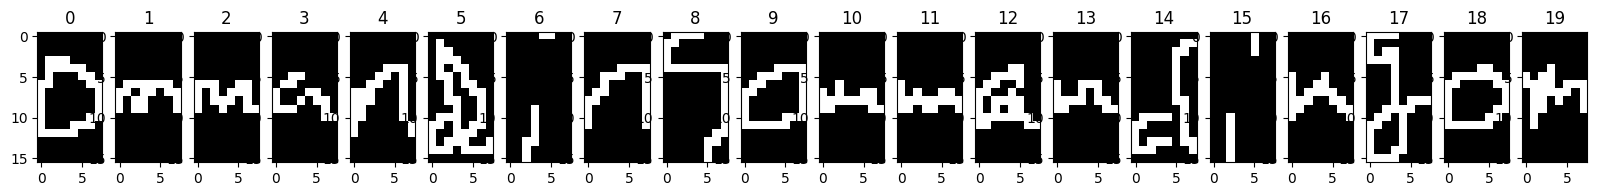

In [7]:
# Understand the profile of OCR raw data
print ("max of labels=", max(dataset1['labels']), " min of labels=", min(dataset1['labels']), 'num of labels=', len(dataset1['labelDic']))
print ("labelDic.keys()=", map(i2l, dataset1['labelDic'].keys()))
print ("Total number of lines=", len(dataset1['ids']))
print ("The shape of features:", np.array(dataset1['features']).shape) 
#52152 the size of xi yi, 128 the number of k? =the size of wi..

print ("The first 10 ids:",dataset1['ids'][:10]) #id from 1 to 52152 (xi)
print ("ids[0]=",dataset1['ids'][0])
print ("labels[0]=", dataset1['labels'][0]) #the alphabetical label the letter is classified to(yi)? labels have the size same as 52152, corresponds to each xi
print("first 10 labels", dataset1['labels'][:10])
print ("The 1st letter is ", i2l(dataset1['labels'][0])) #i2l function converts alphabetical numerical numbers to letter
print ("next_ids[0]=",dataset1['next_ids'][0])
print ("The second letter is ", i2l(dataset1['labels'][1]))
# Show the matrix into an image
def showFeatures(features, num):
    plt.figure(figsize=(num, 6))
    
    for i in range(num):
        npfeature = np.array(features[i])
        plt.subplot(1,num,i+1)
        imshow(npfeature.reshape(16,8), cmap='gray')
        plt.title(i)

showFeatures(dataset1['features'],20)

# f1 = np.array(dataset1['features'])
# f1 = np.hstack([np.ones((f1.shape[0],1)), f1])
# print f1.shape
# dataset1['features'] = f1.tolist()
# d +=1

# Options for Chopping

## Concatenating and structurizing
### version one:
####  (1) find 5000 words, split them into 4000 for training, and 1000 for testing. 
####  (2) chop first 2 characters from each word
####  (3) then, you will have 4000 two-words pairs for training, and 1000 for testing. 
####  (4) construct new structures data based on this pairs. 
 
  e.g.
  
  apple => ap
  
  banana => ba
  
 
### version two:
####  (1) continue reading words from data until you have 4001 characters for training, and 1001 for testing
####  (2) concatenate characters together to form structure features. 
####  (3) you will have the same amount structured data. 
  apple => ap, pp, pl, le
 
 banana => ba, an, na, an, na
  
### version three
####  (1) similar to version two, but add a dummy letter '_' between words.
  apple_banana => ap, pp, pl, le, e_, _b, ba, an, na, an, na
 
### version four
#### (1) similar, but window stride is 2 also, and pad a dummy letter '_', which will be represented as all 0 in the image. 
  apple => ap, pl, e_
  
  banana => ba, na,  na

In [8]:
# Option 1: Extract the first L letters in a word
# You are welcome to try other options

def structurize1(dataset, N, L):
    d_features = len(dataset['features'][0])
    y = dataset['labels']
    X = dataset['features']
    next_id = dataset['next_ids']

    labels = np.zeros((N, L))
    features = np.zeros((N, L*d_features))
    
    # Extract only one structured example
    def extract(iN, loc):
        labels[iN] = y[loc:loc+L]
        features[iN] = np.array(X[loc:loc+L]).ravel().tolist()
        iN += 1
        return iN
    
    iN = 0
    iN = extract(iN, 0)
    
    for key, value in enumerate(y):
        if next_id[key] == -1:
            iN = extract(iN, key+1)
            
            if iN == N:
                break
    
    c = list(zip(labels, features))
    random.shuffle(c)
    labels, features = zip(*c)
    
    return np.array(labels), np.array(features)      

True
[[17. 14. 20.  4. 24. 20.  4. 20.  6. 15.  4. 15.  4. 20.  6.]
 [14. 12.  8.  4. 11.  6.  4.  6. 14. 15. 14. 14. 13. 25. 14.]]


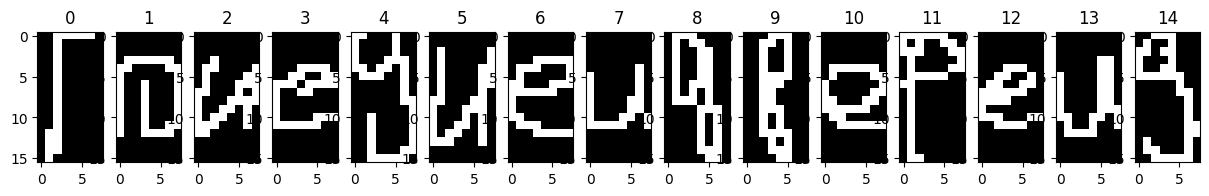

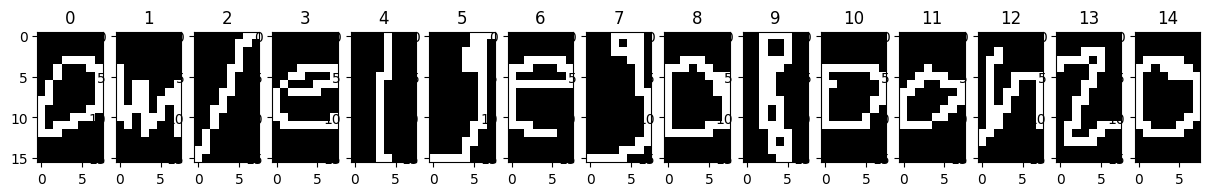

In [9]:
labels1, features1 = structurize1(dataset1, N, L)

print (np.all(labels1[labels1==labels1[0]]))
print (labels1[:15].T)
showFeatures(features1[:,0:128],15)
showFeatures(features1[:,128:256],15)

# Use dlib to classify

In [10]:
print ('N=',N,'L=',L,'d=',d)

N= 5000 L= 2 d= 128


In [11]:
class ThreeClassProblem:
    C = 1

    def __init__(self, samples, labels, L, K, d):
        self.L = L #hyperparameter = 2
        self.K = K #23
        self.d = d #features = 128
        self.num_samples = len(samples) 
        self.num_dimensions = (L*K*d+1) + (L-1) #5890
        self.samples = samples #4000
        self.labels = labels #4000 
        self.loss_for_loop = True
        
 
    def make_psi(self, x, label):
        psi = dlib.vector()
        psi.resize(self.num_dimensions)  # 5890
        psi[0] = x[0]

       
        label_0 = label[0]
        psi_index = label_0  
        psi[psi_index] = x[0]

        # Map the second part of x to psi based on label_0
        for i in range(128):
            psi_index = i + label_0 * 128 + 1  
            psi[psi_index] = x[i + 1]

        # Map the third part of x to psi based on label_1
        label_1 = label[1]
        for i in range(128):
            psi_index = i + label_1 * 128 + 128 * 23 + 1  #
            psi[psi_index] = x[i + 129]

        return psi





    def get_truth_joint_feature_vector(self, idx):
        return self.make_psi(self.samples[idx], self.labels[idx])
    
    def separation_oracle(self, idx, current_solution):
        samp = self.samples[idx]
        psi = [0]*self.num_dimensions
        max1 = -1e10
        max_scoring_label = [0]*L # Initialize max_scoring_label for icm search
        for k in range(Niter):
            for iL in range(self.L):   # Iterate over the window length
                for i in range(self.K):# Change different label for the search of a structured label
                    tmp_label = list(max_scoring_label)
                    tmp_label[iL] = i
                    tmp_psi = self.make_psi(samp, tmp_label)
                    score1 = dlib.dot(current_solution, tmp_psi)
                    
                    loss1 = 0.0
                    if self.loss_for_loop:
                        for j in range(self.L):
                            if self.labels[idx][j] != tmp_label[j]:
                                loss1 += 1.0
                    else:
                        if self.labels[idx] != tmp_label: # Add the conditional "1"
                            loss1 += 1.0

                    if max1 < score1+loss1: # Search for the maximum and update loss, max_scoring_label, and psi
                        max1 = score1 + loss1
                        loss = loss1
                        max_scoring_label[iL] = i
                        psi = tmp_psi

        return loss, psi

In [12]:
# half_index = 257 // 2
# print("halfindex",half_index)
# first_half = x[1:129]
# second_half = x[half_index+1:]



In [13]:
list1 = [1,1,1]
list2= [1,2,3,4,5]
list2[:3] = list1
list2
257//2

128

In [14]:
def cal_accuracy(samples, labels, problem, weights, K):
    predictions = []
    for samp in samples:
        prediction = [0]*L # Initialize max_scoring_label for icm search
        Niter = 2                 # The hyper-parameter for icm search
        max1 = -1e10              # The max value during maximizing our target function
        for k in range(Niter):
            for iL in range(L):   # Iterate over the window length
                for i in range(K):# Change differnet label for the search of a structured label
                    tmp_label = list(prediction)    # Copy the current best prediction
                    tmp_label[iL] = i                # Modify the label at position iL
                    psi1 = problem.make_psi(samp, tmp_label)
                    score1 = dlib.dot(weights, psi1)

                    if max1 < score1:
                        max1 = score1
                        prediction[iL] = i
        predictions.append(prediction)
    
    
    errCnt = 0
    for i in range(len(predictions)):
        if predictions[i] != labels[i]:
            errCnt += 1

    return 1.0-float(errCnt)/float(len(predictions))

In [15]:
le1 = preprocessing.LabelEncoder()
nplabels1  = le1.fit_transform(labels1.ravel()).reshape(labels1.shape)
npsamples1 = np.hstack([np.ones((N,1)), features1]) # Add ones for bias
K1 = len(le1.classes_)
print ('K1=', K1)

tr_labels  = nplabels1[:int(N*0.8)].astype(int).tolist()
tr_samples = npsamples1[:int(N*0.8)].astype(int).tolist()
te_labels  = nplabels1[int(N*0.8):].astype(int).tolist()
te_samples = npsamples1[int(N*0.8):].astype(int).tolist()

def profiling(labels):
    TrDic = {}
    for i in np.array(labels).ravel():
        if i not in TrDic:
            TrDic[i] = 1
        else:
            TrDic[i] += 1
    return TrDic
print (profiling(tr_labels))
print (profiling(te_labels))

K1= 23
{15: 279, 13: 917, 11: 572, 17: 656, 7: 390, 4: 1037, 21: 84, 10: 203, 6: 217, 14: 315, 12: 812, 22: 222, 0: 655, 20: 123, 19: 111, 2: 448, 18: 300, 16: 116, 1: 118, 5: 110, 3: 127, 9: 123, 8: 65}
{2: 147, 4: 254, 12: 202, 6: 61, 13: 240, 17: 147, 10: 58, 0: 170, 14: 81, 19: 29, 11: 139, 1: 28, 18: 69, 21: 33, 16: 30, 5: 25, 22: 46, 15: 85, 20: 24, 8: 11, 9: 24, 7: 78, 3: 19}


In [16]:
# print(tr_labels)
# label = tr_labels
# print(len(tr_labels))
# print(label[0])
# print(label[0][1])

# print(tr_samples)
# print(len(tr_samples))

In [17]:
problem = ThreeClassProblem(tr_samples, tr_labels, L, K1, d)

start_train = timeit.default_timer()
weights = dlib.solve_structural_svm_problem(problem)
end_train = timeit.default_timer()
print ("Training time elapsed:", end_train - start_train, "s")
pickle.dump(weights, open('weights1_1.obj', 'wb'))
#pickle.dump(weights, open('weights1_1.obj', 'w'))


In [ ]:
weights_load = pickle.load(open('weights1_1.obj','rb'))
#weights_load = pickle.load(open('weights1_1.obj','r'))

print ("Training accuracy=", cal_accuracy(tr_samples, tr_labels, problem, weights_load, K1))
print ("Test accuracy=", cal_accuracy(te_samples, te_labels, problem, weights_load, K1))

Training accuracy= 0.48675
Test accuracy= 0.43500000000000005
